# **Twitter Sentimental Analysis**

### **Introduction:**
This document provides information about gathering data (tweets) from Twitter in real time using the Twitter API and building a model that would determine if a tweet is positive, negative, or neutral. It also discusses the pre-processing and the GaussianNB model that was used to train the data. The article concludes by discussing how to utilize the Flask framework to build a user interface for interacting with the model and making predictions based on real-time tweets.

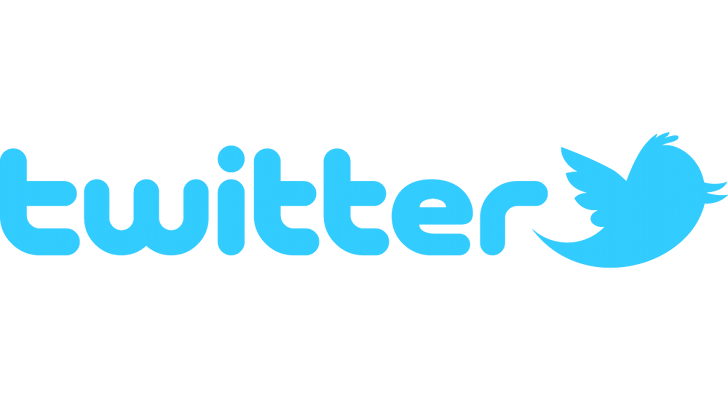

## Index

1. Getting tweets from twitter

2. Pre-Processing Data

3. Machine Learning Modeling

   3.1 Gaussian NB Model

   3.2 Tensor flow based model

   3.3 Train the Data

4. Model Comparison

In [55]:
import pandas as pd
import numpy as np

In [56]:
import time
from time import sleep

##1. Getting tweets from twitter


In [57]:
import tweepy
from tweepy import OAuthHandler
class TwitterClient(object): 
    def __init__(self):
        # Access Credentials 
        consumer_key = 'H2BC0VG4ryxSRSOWu55v5gLq7'
        consumer_secret = 'vbPsG2SyFW9V45OVN4Zd7T5Sb0BlEpQ0O5NOY6VOp8eEks6jZe'
        access_token = '4777206672-mKdpANklpEAmix8SWYxnZPbH4ix354cZ7P6tjjD'
        access_token_secret = '0GLH8vvuzwoePOvdeczyByWWExEXzBlDPfP7pjHlCWUJ8'
        try: 
            # OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Twitter Authentication Failed - \n{str(e)}") 

    # Function to fetch tweets
    def get_tweets(self, query, maxTweets = 1000): 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100
        
        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break
                    
                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)
     


In [58]:
selenium_client = TwitterClient()

tweets_df = selenium_client.get_tweets('environment')

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets


In [59]:

tweets_df.head()

,tweets
0,RT @manishathakare1: My champ #ShivThakare U ...
1,RT @253Coug_: Ron Store Jr. is coming back to ...
2,'A remarkable storyteller': Remembering Gary S...
3,@AnimalsHolbox: 'A remarkable storyteller': Re...
4,"RT @Lwanda_L: Our bodies, our minds and our sp..."


##2.Pre-Processing Data

In [60]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    if polarity_scores['neg'] > polarity_scores['pos']:
        return 'negative'
    else:
        return 'positive'

def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0: 
        return 'negative'
    else:
        return 'neutral'

In [61]:
import re
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
     

In [62]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split()        if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets

In [63]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)


,tweets,tidy_tweets
0,RT @manishathakare1: My champ #ShivThakare U ...,My champ #ShivThakare U r Shining you r the so...
1,RT @253Coug_: Ron Store Jr. is coming back to ...,on Store Jr. is coming back to #Wazzu. He says...
2,'A remarkable storyteller': Remembering Gary S...,'A remarkable storyteller':emembering Gary Str...
3,@AnimalsHolbox: 'A remarkable storyteller': Re...,'A remarkable storyteller':emembering Gary Str...
4,"RT @Lwanda_L: Our bodies, our minds and our sp...","Our bodies, our minds and our spirits are bein..."
...,...,...
569,@AbijitG Wtf is this. Punching down on Muslims...,@AbijitG Wtf is this. Punching down on Muslims...
570,RT @hassanaftabs: A good read by @DrGaryFuller...,A good read by @DrGaryFuller on learning from ...
571,RT @YungKundalini: People don’t understand jus...,People don’t understand just how much your men...
572,RT @malware_traffic: 2022-12-02 (Friday) - I c...,2022-12-02 (Friday) - I created and posted a v...


In [64]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


In [65]:

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_set = set(stopwords.words("english"))
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))

tweets_df['absolute_tidy_tweets'] = cleaned_tweets
     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:

import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Pac

True

In [67]:
from nltk.stem import WordNetLemmatizer
# Aurtharization
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
# Finding Lemma for each word
word_lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
#joining words into sentences (from where they came from)
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet

In [68]:
tweets_df


,tweets,tidy_tweets,absolute_tidy_tweets
0,RT @manishathakare1: My champ #ShivThakare U ...,My champ #ShivThakare U r Shining you r the so...,My champ #ShivThakare U r Shining r sorce posi...
1,RT @253Coug_: Ron Store Jr. is coming back to ...,on Store Jr. is coming back to #Wazzu. He says...,Store Jr coming back #Wazzu He say postgame sh...
2,'A remarkable storyteller': Remembering Gary S...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...
3,@AnimalsHolbox: 'A remarkable storyteller': Re...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...
4,"RT @Lwanda_L: Our bodies, our minds and our sp...","Our bodies, our minds and our spirits are bein...",Our body mind spirit terraformed The planet te...
...,...,...,...
569,@AbijitG Wtf is this. Punching down on Muslims...,@AbijitG Wtf is this. Punching down on Muslims...,AbijitG Wtf Punching Muslims environment You c...
570,RT @hassanaftabs: A good read by @DrGaryFuller...,A good read by @DrGaryFuller on learning from ...,A good read DrGaryFuller learning Londons smog...
571,RT @YungKundalini: People don’t understand jus...,People don’t understand just how much your men...,People dont understand much mental health over...
572,RT @malware_traffic: 2022-12-02 (Friday) - I c...,2022-12-02 (Friday) - I created and posted a v...,Friday I created posted video Youtube titled P...


In [69]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=50)
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english', max_features=50)
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df['absolute_tidy_tweets'])

In [70]:
bow_word_feature


<574x50 sparse matrix of type '<class 'numpy.int64'>'
	with 845 stored elements in Compressed Sparse Row format>

In [71]:
tweets_df

,tweets,tidy_tweets,absolute_tidy_tweets
0,RT @manishathakare1: My champ #ShivThakare U ...,My champ #ShivThakare U r Shining you r the so...,My champ #ShivThakare U r Shining r sorce posi...
1,RT @253Coug_: Ron Store Jr. is coming back to ...,on Store Jr. is coming back to #Wazzu. He says...,Store Jr coming back #Wazzu He say postgame sh...
2,'A remarkable storyteller': Remembering Gary S...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...
3,@AnimalsHolbox: 'A remarkable storyteller': Re...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...
4,"RT @Lwanda_L: Our bodies, our minds and our sp...","Our bodies, our minds and our spirits are bein...",Our body mind spirit terraformed The planet te...
...,...,...,...
569,@AbijitG Wtf is this. Punching down on Muslims...,@AbijitG Wtf is this. Punching down on Muslims...,AbijitG Wtf Punching Muslims environment You c...
570,RT @hassanaftabs: A good read by @DrGaryFuller...,A good read by @DrGaryFuller on learning from ...,A good read DrGaryFuller learning Londons smog...
571,RT @YungKundalini: People don’t understand jus...,People don’t understand just how much your men...,People dont understand much mental health over...
572,RT @malware_traffic: 2022-12-02 (Friday) - I c...,2022-12-02 (Friday) - I created and posted a v...,Friday I created posted video Youtube titled P...


In [72]:

for row in tweets_df.itertuples():
    tweet = tweets_df.at[row[0], 'absolute_tidy_tweets']
    result=fetch_sentiment_using_textblob(tweet)
    tweets_df.at[row[0], 'Sentiment']=result

In [73]:
tweets_df['Sentiment'].unique()


array(['neutral', 'positive', 'negative'], dtype=object)

In [74]:
tweets_df.head(200)


,tweets,tidy_tweets,absolute_tidy_tweets,Sentiment
0,RT @manishathakare1: My champ #ShivThakare U ...,My champ #ShivThakare U r Shining you r the so...,My champ #ShivThakare U r Shining r sorce posi...,neutral
1,RT @253Coug_: Ron Store Jr. is coming back to ...,on Store Jr. is coming back to #Wazzu. He says...,Store Jr coming back #Wazzu He say postgame sh...,neutral
2,'A remarkable storyteller': Remembering Gary S...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...,positive
3,@AnimalsHolbox: 'A remarkable storyteller': Re...,'A remarkable storyteller':emembering Gary Str...,A remarkable storytelleremembering Gary Striek...,positive
4,"RT @Lwanda_L: Our bodies, our minds and our sp...","Our bodies, our minds and our spirits are bein...",Our body mind spirit terraformed The planet te...,neutral
...,...,...,...,...
195,#ClimateChange #ClimateCrisis #ClimateEmergenc...,#ClimateChange #ClimateCrisis #ClimateEmergenc...,#ClimateChange #ClimateCrisis #ClimateEmergenc...,neutral
196,RT @OUTASA: The #OUTA team salutes @ferrial_ad...,The #OUTA team salutes @ferrial_adam as well! ...,The #OUTA team salute ferrialadam well Althoug...,positive
197,I would have peace if I left this environment ...,I would have peace if I left this environment ...,I would peace I left environment controlling p...,neutral
198,RT @ReutersScience: The first round of negotia...,The first round of negotiations on a global pl...,The first round negotiation global plastic tre...,positive


In [75]:
target_variable = tweets_df['Sentiment'].apply(lambda x: 0 if x=='negative' else 1 if x=='positive' else -1 )


## 3.Machine Learning Modeling

###3.1 Gaussian NB Model

Gaussian Naive Bayes supports continuous valued features and models each as conforming to a Gaussian (normal) distribution.

Naive Bayes is a basic but effective probabilistic classification model in machine learning that draws influence from Bayes Theorem. Bayes theorem is a formula that offers a conditional probability of an event A taking happening given another event B has previously happened. Gaussian Naive Bayes classifier is employed when the predictor values are continuous and are expected to follow a Gaussian distribution.

Trained the model with both the bag of words and tf-idf and the reason being that the stop words might not have been complete removed in bag of words approach and in tf-idf , idf removes the unwanted words which makes it more cleaner and help model train with relevant data.



In [76]:

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)
    import joblib
    from joblib import dump

    # dump the pipeline model
    dump(naive_classifier, filename="text_classification.joblib")
    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())
    
    # calculating f1 score
    accuracy=metrics.accuracy_score(predictions,y_test)
    print(f'Accuracy Score - {accuracy}')
     

In [77]:

X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=870)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.24855491329479767


In [78]:
X_train


<401x50 sparse matrix of type '<class 'numpy.int64'>'
	with 622 stored elements in Compressed Sparse Row format>

In [79]:
X_test


<173x50 sparse matrix of type '<class 'numpy.int64'>'
	with 223 stored elements in Compressed Sparse Row format>

In [80]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=870)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.23121387283236994


### Downloading the created model
dump ( naive_classifier , filename =" text_classification . joblib ") The model which has been trained in the previous step has been stored and downloaded from colab so that it can be used with flask and integrated to a UI (web application)



In [81]:

from google.colab import files
files.download('text_classification.joblib') 

from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.2 Tensor flow based model - LSTM
We start with defining the input layer, and next is embedding. Embeddings provide the presentation of words and their relative meanings. Like in this, we are feeding the limit of maximum words, lenght of input words and the inputs of previous layer. LSTM (long short term memory) save the words and predict the next words based on the previous words. LSTM is a sequance predictor of next coming words. By receiving inputs from the Faltten layer, the Dense layer reduces the outputs. The dense layer takes all of the previous layer’s inputs, does calculations, and sends 256 outputs.The activation function is a node that is placed at the end of or in between the layers of a neural network model. The activation function assists in determining which neurons should be passed and which should fire. So, given an input or a group of inputs, the activation function of a node defines the output of that node. Finally the drop out layers prevent over fitting.

In [82]:
max_len=50
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model 

In [83]:
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
     

In [84]:

import joblib
from joblib import dump

    # dump the pipeline model
dump(model, filename="nn.joblib")

['nn.joblib']

In [85]:
X=tweets_df.absolute_tidy_tweets
y=target_variable
     

In [86]:
max_len = 50
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
     

In [87]:
sequences_matrix.shape

X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)


## 3.3 Train The Data

In [88]:
print('Training the data')

history=model.fit(X_train,Y_train,batch_size=80,epochs=20)
print('Training data ended')
     

Training the data
Epoch 1/20
6/6 [==============================] - 2s 34ms/step - loss: 0.6632 - accuracy: 0.1771
Epoch 2/20
6/6 [==============================] - 0s 32ms/step - loss: 0.5565 - accuracy: 0.1596
Epoch 3/20
6/6 [==============================] - 0s 31ms/step - loss: 0.2291 - accuracy: 0.1596
Epoch 4/20
6/6 [==============================] - 0s 32ms/step - loss: -0.2810 - accuracy: 0.1596
Epoch 5/20
6/6 [==============================] - 0s 34ms/step - loss: -0.4112 - accuracy: 0.1596
Epoch 6/20
6/6 [==============================] - 0s 31ms/step - loss: -0.5199 - accuracy: 0.1596
Epoch 7/20
6/6 [==============================] - 0s 31ms/step - loss: -0.6919 - accuracy: 0.1596
Epoch 8/20
6/6 [==============================] - 0s 35ms/step - loss: -1.0205 - accuracy: 0.1596
Epoch 9/20
6/6 [==============================] - 0s 37ms/step - loss: -1.1657 - accuracy: 0.1596
Epoch 10/20
6/6 [==============================] - 0s 38ms/step - loss: -1.3026 - accuracy: 0.1596
Epoc

In [89]:
accr1 = model.evaluate(X_test,Y_test)


6/6 [==============================] - 1s 9ms/step - loss: -11.5473 - accuracy: 0.2081


In [90]:
print(accr1[1])


0.20809248089790344


## 4.Model Comparison


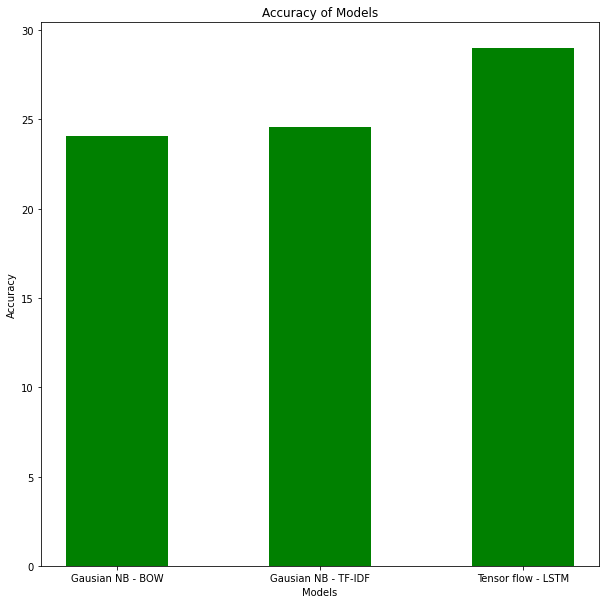

In [91]:
import matplotlib.pyplot as plt
data = {'Gausian NB - BOW':24.1, 'Gausian NB - TF-IDF':24.6, 'Tensor flow - LSTM':29,
        }
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 10))
 
# Display the bar plot
plt.bar(courses, values, color ='green',
        width = 0.5)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")

plt.savefig("model-accuracy.pdf")
     

In [92]:
from google.colab import files
files.download('model-accuracy.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>